In [1]:
# some initialization stuff
%run init.py
%matplotlib inline

<IPython.core.display.Latex object>

In [2]:
import matplotlib.image as mpimg

def std_full(T):
    means = T.mean(dim=0, keepdim=True)
    stds = T.std(dim=0, keepdim=True)
    return ((T - means) / stds), means, stds

def standardize(T):
    return std_full(T)[0]

def std_inverse(T, means, stds):
    k = T.size()[1]
    return T*stds[:,:k] + means[:,:k]

def normalize(T):
    Tv = T.view(T.size(0), -1)
    Tv -= Tv.min()
    Tv /= Tv.max()
    return Tv

def to_coefficients(T):
    return T / T.sum(0, keepdim=True)[0]

def plot_scores(x=0,y=0):
    ort = torch.tensor([[x], [y]], dtype=torch.float32 )
    colors=['green', 'orange']
    fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
    ax[0].set_ylabel(us.columns[1])

    for a in ax:
        a.set_xlabel(us.columns[0])
        a.scatter(X_us[:,0],X_us[:,1])
        l,r = a.get_xlim()
        b,t = a.get_ylim()
       

        x = np.linspace(l,r,20)
        y = (ort[1]/ort[0])*x 
        a.plot(x,y, c='orange')

    for i in range(len(X_us)):
        m =  np.dot(np.divide(np.dot(ort,ort.T), np.dot(ort.T,ort)), np.array([X_us[i,0],X_us[i,1]]).T)
        ax[1].plot([X_us[i,0],m[0]],[X_us[i,1],m[1]], c='green')
        ax[1].scatter(m[0], m[1], marker='x', c='k')

    fig.tight_layout()
    plt.show()

# Unsupervised methods

<center>
    <img src="images/unsupervised.jpg" width="80%"/>
</center>

## Unsupervised learning (1)

+ What should we do, if there are no labels?
    - There is no simple goal for analysis, the methods are more subjective
    - However, these methods are very important in various applications 
+ Can we represent the data in some informative way and study its properties?

+ Examples:
    - Documents can be grouped by words occurring in them
    - Patients by results of various tests
    - Products by technical features
+ Unlabeled data is often more easy to get! 
    - No mighty oracle providing the labels is required

## Unsupervised learning (2)
+ Dimensionality reduction:
    - Given a set of features and their observations, can we derive new features that are better suitable for analysis?
    - *Principal Components Analysis* (PCA): a tool used for data visualization or data preprocessing before supervised techniques are applied

# Principal Components Analysis (PCA)
+ Assume you face a dataset with a large set of correlated features
+ PCA allows us to summarize this set with a smaller number of "synthetic" features that collectively explain most of the variance in the original dataset
+ Given a dataset with $n$ observations of $p$ features

## Example: US arrests

+ Consider a data set containing statistics for each of the 50 US states in 1973:
    - arrests per 100,000 residents for assault, murder, and rape;
    - percent of the population living in urban areas

In [3]:
us = pd.read_csv('data/USArrests.csv')
states = us.pop(us.columns[0])
us.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


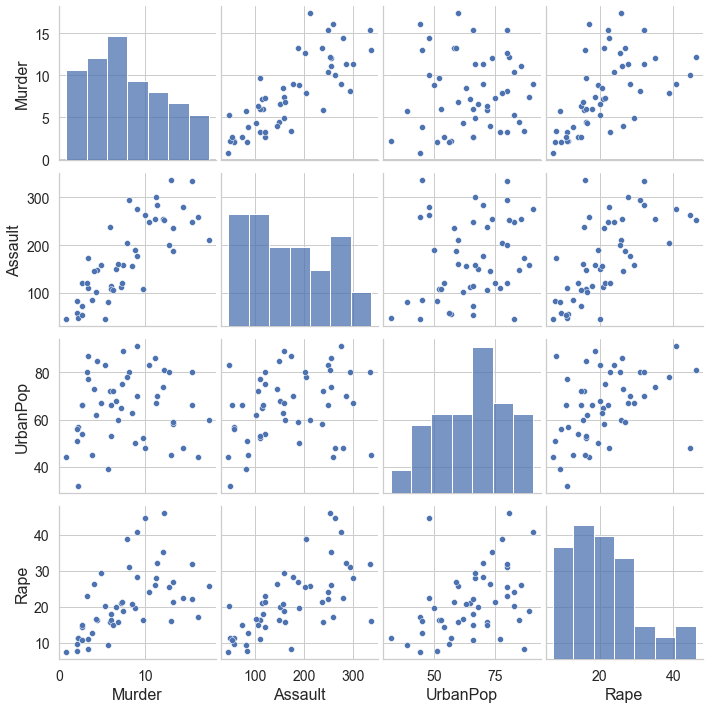

In [4]:
sns.pairplot(us);

In [5]:
us.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


## Standardization
+ Since we are only interested in variance it is recommended to rescale each feature vector
\begin{equation*}
x_{ij}'=\frac{x_{ij}-\mu_i}{\sigma_i}
\end{equation*}
where 
    - $x_{ji}$ is an observed value, 
    - $\mu_i$ is the mean of the population, can be estimated using the average $\overline{x}_i$ of all values observed for the feature $i$
    - $\sigma_i$ is the standard deviation of the population, can be estimated as $$S_i=\sqrt{\frac{1}{n-1}\sum{(x_{ji}-\overline{x}_i})^2}$$
    
+ Replacement of feature values with standard scores $x_{ij}'$ is called *standartization* and is recommended for many ML algorithms
+ The matrix of standard scores 
  - is *centered* - subtraction of the mean of every column from its values, and
  - has *unit standard deviation* - division by the standard deviation of the data in this column

In [6]:
# Application of the standard scaler to the first two columns 
# (for simplicity)
T_us = torch.tensor(us.values, dtype=torch.float32)
X_us = standardize(T_us)[:,[0,1]]
df_us = pd.DataFrame(data=X_us.numpy(), columns=us.columns[[0,1]])
df_us.describe()

,Murder,Assault
count,5.000000e+01,5.000000e+01
mean,-1.245737e-07,7.584691e-08
std,1.000000e+00,9.999999e-01
min,-1.604405e+00,-1.509042e+00
25%,-8.524836e-01,-7.410814e-01
50%,-1.235218e-01,-1.411126e-01
75%,7.948552e-01,9.388313e-01
max,2.206860e+00,1.994776e+00


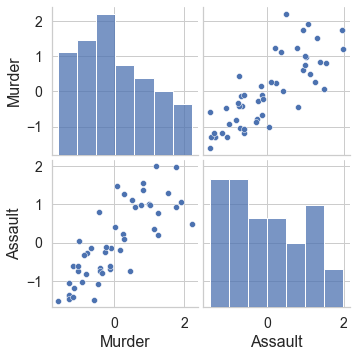

In [7]:
sns.pairplot(df_us);

In [8]:
interact(plot_scores, x=fixed(1), y=(-1,1,0.2));

interactive(children=(FloatSlider(value=0.0, description='y', max=1.0, min=-1.0, step=0.2), Output()), _dom_cl…

## Principal Components

+ Given an $n \times p$ matrix $\vec{X}$ of observations of $p$ random variables
+ Principal component $\vec{z}_i$ is a normalized linear combination, where last condition is the normalization requirement

\begin{equation*}
\vec{z}_i=\phi_{1i}\vec{x}_1+\dots+\phi_{pi}\vec{x}_p \text{ such that } \sum_{1\leq j \leq p} \phi_{ji}^2=1
\end{equation*}

+ Vector $\vec{\phi}_i=[\phi_{1i},\dots,\phi_{pi}]^\top$ is called a *principal direction* or *axis* of a principal component $\vec{z}_i$
+ Geometrically, the axis $\vec{\phi}_1$ of the first component $\vec{z}_1$ defines a direction in which the data vary the most, and so on
+ Normalization constraint is required, since otherwise these values can be arbitrary large
+ Values $z_{1i}, \dots, z_{ni} \in \vec{z}_i$ are called *scores* of the principal component $\vec{z}_i$

## Computation

+ *Goal*: find a sequence of principal components that have **maximal variance** and are **mutually uncorrelated**
+ Computation of the first principal component corresponds to the optimization problem
\begin{equation*}
\max_{\phi_{11},\dots,\phi_{p1}} \frac{1}{n}\sum_{i=1}^n{z_{i1}^2} \text{ subject to } \sum_{1\leq j \leq p} \phi_{j1}^2=1
\end{equation*}
where $z_{i1}=\phi_{1i}x_1+\dots+\phi_{pi}x_p$
    + That is, we maximize the sample variance of the scores $z_{i1}$ for $1\leq i \leq n$ 
    + This optimization problem is usually solved using the *singular value decomposition* of the matrix $\vec{X}$ 

### Computation details

+ The PCA optimization problem is solved using the eigenvector decomposition of the covariance matrix $\vec{C}$ defined as $$\vec{C}=\frac{\vec{X}^\top\vec{X}}{(n-1)}$$ where $\vec{X}$ is a *centered* $n\times m$ matrix of observations
+ Eigenvalue decomposition of $\vec{C}=\vec{V}\vec{\Lambda}\vec{V}^\top$
   - $\vec{V}$ is a matrix of eigenvectors corresponding to principle directions (axes)
   - Projection of data on these axes $\vec{X}\vec{V}$ gives principal components (scores)
   - $\vec{\Lambda}$ indicate the amount of variance explained
+ Solution with SVD of $\vec{X}=\vec{U}\vec{D}\vec{V}^\top$
    $$ \vec{C} = \frac{1}{n-1}\vec{V}\vec{D}\vec{U}^\top \vec{U}\vec{D}\vec{V}^\top   = \vec{V}\frac{\vec{D}^2}{n-1}\vec{V}^\top$$
  + $\vec{U}^\top \vec{U} = \vec{I}$ because $\vec{U}$ is orthogonal by the definition of the decomposition
  + $\Rightarrow$ columns in $\vec{V}$ are principal directions (eigenvectors of the covariance matrix)
  + $\Rightarrow$ projection of data on these directions $\vec{X}\vec{V} = \vec{U}\vec{D}\vec{V}^\top\vec{V}=\vec{U}\vec{D}$ gives us the scores of the components
  + $\Rightarrow$ loadings - directions $\vec{V}$ scaled by square roots of eigenvalues $\vec{\Lambda}$ of the covariance matrix - are given by columns of 
  $${\vec{V}\frac{\vec{D}}{\sqrt{n-1}}} ~~~~\text{since} ~~~~\vec{\Lambda} = \frac{\vec{D}^2}{n-1}$$

## Example: US arrests (small)

+ Apply PCA to find the first two columns of the *standardized* US Arrests dataset 

In [9]:
def std_PCA(X, k=2):   
    n = X.size()[0]
    if (k>X.size()[1]): 
        raise ValueError('k must be smaller or equal to {}'.format(X.size()[1]))

    u,d,v = torch.svd(X)
    d = torch.diag(d)
    comps = v[:,:k].t()
    var_exp = torch.matmul(d,d)/(n-1)
    scores =  torch.matmul(u,d)[:,:k]
    loadings = torch.matmul(v, torch.sqrt(var_exp))
    return (scores, comps, torch.diag(var_exp)[:k], loadings[:k].t())

sc_s, cs_s, ve_s, l_s = std_PCA(X_us)
print("Direction of the first component: ({:.3f}, {:.3f})".format(cs_s[0,0], cs_s[0,1]))
print("Direction of the second component:  ({:.3f}, {:.3f})".format(cs_s[1,0], cs_s[1,1]))

Direction of the first component: (-0.707, -0.707)
Direction of the second component:  (0.707, -0.707)


+ The first principal axis $\phi_1=(-0.707,-0.707)$ defines a direction in the feature space along which the data varies most
\begin{equation*}
\vec{z}_1=-0.707\vec{m} + (-0.707)\vec{a}
\end{equation*}
+ The second axis - the second direction
\begin{equation*}
\vec{z}_2=0.707\vec{m} + (-0.707)\vec{a}
\end{equation*}

- Since we have $50$ observations, the score vectors $\vec{z}_1$ and $\vec{z}_2$ have also $50$ values
- The original data points and a principle direction are shown on the left
- Projections of the data points on the axis - on the right

In [10]:
@interact(i=(0,1))
def plot_dirs(i=0):
    plot_scores(cs_s[i,0], cs_s[i,1])

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

### Loading vectors

+ A *loading vector* is a principal direction scaled by the square root of the variance of the original variable it explains 
    + The green arrow shows the direction of the first component and the orange one -- of the second
    + Length of the vectors - proportion of the variance explained

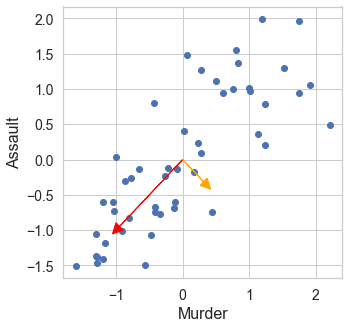

In [11]:
colors=['red', 'orange']
fig = plt.figure(figsize=(5,5))
plt.scatter(X_us[:,0],X_us[:,1])
plt.xlabel(us.columns[0])
plt.ylabel(us.columns[1])

for i in range(2):
    plt.arrow(0, 0, l_s[i,0], l_s[i,1], ec=colors[i],
              head_width=0.15, head_length=0.15, fc=colors[i])

## Example: US Arrests (full)

- All four components of the data set 

In [12]:
X_full = standardize(T_us)
sc_f, cs_f, ve_f, l_f = std_PCA(X_full, k=4)
print("Principal directions are given in the rows")
pd.DataFrame(data=cs_f.numpy(), columns=us.columns)

Principal directions are given in the rows


,Murder,Assault,UrbanPop,Rape
0,-0.535899,-0.583184,-0.278191,-0.543432
1,0.418181,0.187985,-0.872806,-0.167319
2,-0.341233,-0.268148,-0.378016,0.817778
3,0.649228,-0.743407,0.133878,0.089024


- Visualizing the impact of variables on each component can be done using heat maps

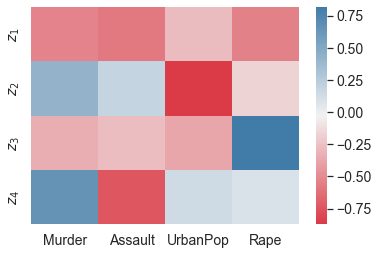

In [13]:
sns.heatmap(cs_f, cmap=sns.diverging_palette(10,240, as_cmap=True),
            yticklabels=["$z_"+str(x) + "$" for x in range(1,len(cs_f)+1)],
            xticklabels=list(us.columns));

- Variance explained by each component

In [14]:
def plot_var_exp(ve):
    fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True)
    ax[0].bar(range(1,len(ve)+1), ve)
    ax[0].set_ylabel('Variance explained')
    ax[1].set_ylabel('Cumulative variance explained')
    ax[1].bar(range(1,len(ve)+1), torch.cumsum(to_coefficients(ve), dim=0), color='green')
    fig.tight_layout()
    plt.show()

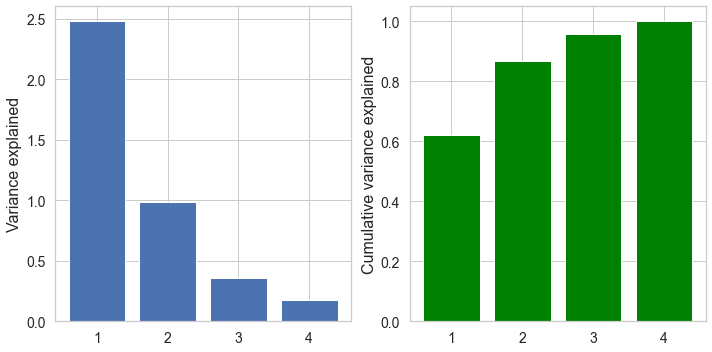

In [15]:
plot_var_exp(ve_f)

## Example: US Arrests (biplot)

+ Biplot shows both principal component scores and loadings

In [16]:
def biplot(z1, z2, sc, comps, obs, features, colors):
    x, y = sc[:,z1], sc[:,z2]
    
    fig = plt.figure(figsize=(10,10))
    plt.xlabel("$z_{}$".format(z1))
    plt.ylabel("$z_{}$".format(z2))

    sx = (x.max() - x.min())/2
    sy = (y.max() - y.min())/2

    plt.scatter(x,y)
    for i in range(len(obs)):
        plt.text(x[i], y[i], obs[i], ha='center', fontsize=12)

    vec = np.transpose(comps[[z1,z2], :])
    
    for i in range(len(vec)):
        plt.arrow(0, 0, vec[i,0]*sx, vec[i,1]*sy, ec=colors[i],
                  head_width=0.1, head_length=0.1, fc=colors[i])
        plt.text(vec[i,0]*sx*1.2, vec[i,1]*sy*1.2, features[i], 
                 color = colors[i])

    plt.grid()

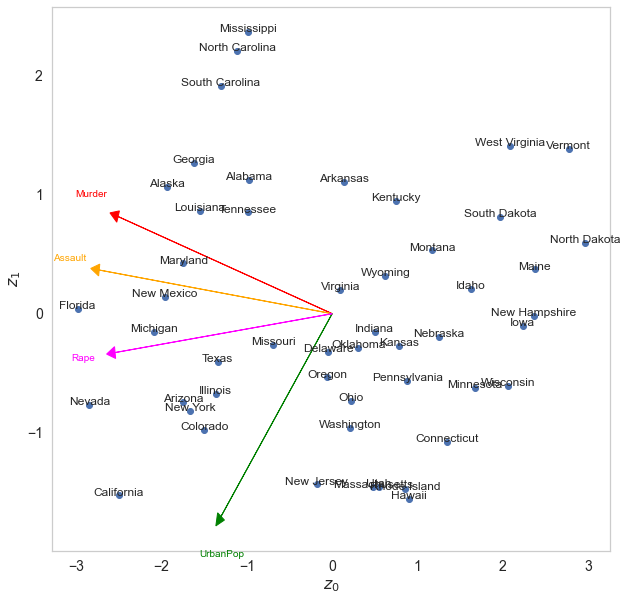

In [17]:
z1, z2 = 0, 1
biplot(z1, z2, sc_f, l_f, states, us.columns, colors=['red', 'orange', 'green', 'magenta'])

+ State names - scores for the first two principal components
+ Arrows - show loading vectors of the first two principal components (axes top and right)
+ First loading vector places appr. equal weight on *Assault*, *Murder* and *Rape* - roughly - measure of overall rates of serious crimes
    - Three "crime" variables are correlated - states with a high rate in one crime tend to have higher rates in other crimes
+ Second vector places most weight on *UrbanPop* and much less on other features
+ Score vectors:
    - California high urbanization and crime rate
    - Vermont low urbanization and low crime rate
    - Florida high crime rate and average urbanization

## Example: Iris

- Consider a data set containing measurement of 150 iris flowers:
    - 3 types of flowers: setosa, versicolor, and virginica
    - 4 features: width and length of sepal and petal leaves


<center>
    <img src="images/slide8.png" width="50%"/>
</center>

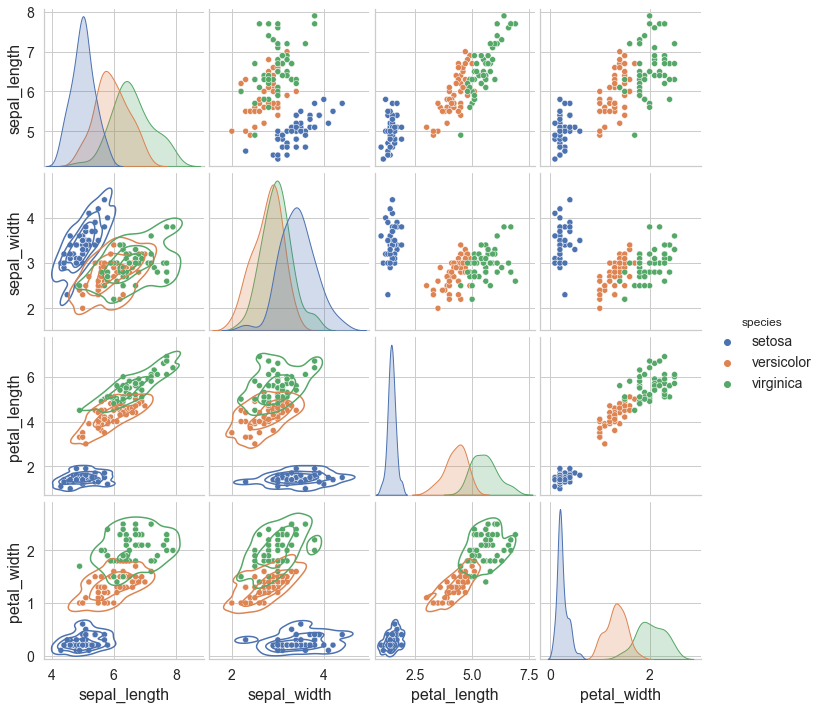

In [18]:
dfi = sns.load_dataset("iris")
fig = sns.pairplot(dfi, hue="species")
fig.map_lower(sns.kdeplot, levels=4, color=".2");

In [19]:
X_iris = standardize(torch.tensor(dfi.iloc[:,0:4].values, dtype=torch.float32))
sc_i, cs_i, ve_i, l_i = std_PCA(X_iris, k=4)
print("Principal directions are given in the rows")
pd.DataFrame(data=cs_i.numpy(), columns=dfi.columns[0:4])

Principal directions are given in the rows


,sepal_length,sepal_width,petal_length,petal_width
0,0.521066,-0.269348,0.580413,0.564857
1,-0.377418,-0.923296,-0.024492,-0.066942
2,0.719566,-0.244382,-0.142126,-0.634273
3,0.261286,-0.123510,-0.801449,0.523597


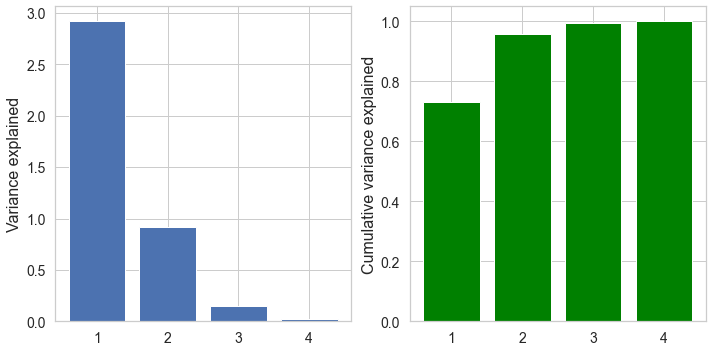

In [20]:
plot_var_exp(ve_i)

- Biplot for the two first principal components of iris data set

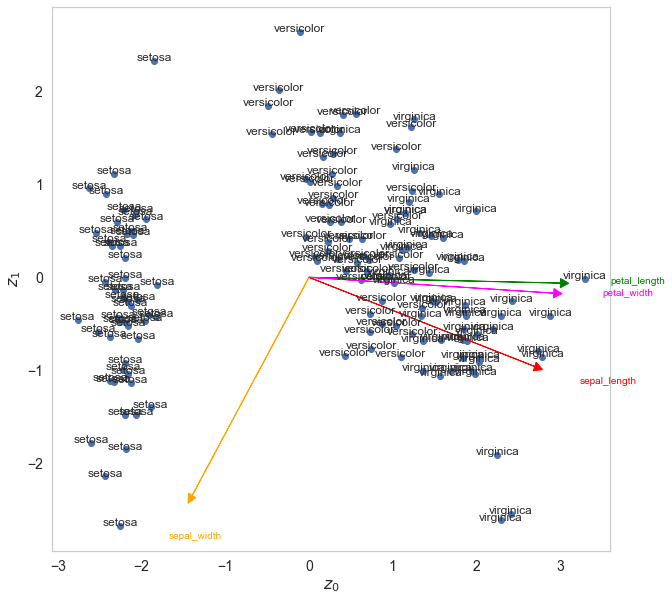

In [21]:
z1, z2 = 0, 1
biplot(z1, z2, sc_i, l_i, dfi["species"], dfi.columns, 
       colors=['red', 'orange', 'green', 'magenta'])

## Example: Image compression

+ Application of PCA to every of the three color channels of an image
+ The result shows an image obtained by using only 15 out of 320 principle components

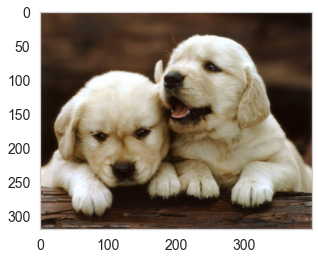

In [22]:
img = mpimg.imread('puppy.jpeg')
plt.imshow(img)
plt.grid(None);

In [23]:
def extractComps(img, comps=30):
    out=[]
    fig, ax = plt.subplots(1, 3, sharex=True, figsize=(15,5))
    colors=['red', 'green', 'blue']
    for i in range(len(colors)):
        sc, cp, ve, l = std_PCA(img[:,:,i], k=comps)
        img_t = torch.matmul(sc, cp)
        print("{}: scores {} and components {}".format(colors[i], sc.shape, cp.shape))
        ax[i].bar(range(1,comps+1), to_coefficients(ve), color=colors[i])
        out.append(normalize(img_t))

    fig.tight_layout()
    return out

In [24]:
@interact(comps=(5,300,5), continious_update=False)
def compress(comps=15):
    fig, ax = plt.subplots(1,2, figsize=(10,15))
    ax[0].imshow(img)
    ax[0].grid(False)
    ax[1].imshow(torch.dstack(extractComps(torch.tensor(img, dtype=torch.float32), comps)))
    ax[1].grid(False)

interactive(children=(IntSlider(value=15, description='comps', max=300, min=5, step=5), Output()), _dom_classe…

+ Analysis of observations:
    - Which of the observations are of the same origin?
    - *Clustering*: a broad class of methods for discovering unknown subgroups in data

# Clustering

## Grouping the observations
+ *Clustering* refers to number of methods for finding subgroups, so called  *clusters*, in a dataset.
+ Every group is distinct and comprises observations that can be considered as *similar*

<p class="fragment step-fade-in myalert"> 
What actually does "similar" mean? How can we measure the similarity between two or more observations?
</p>

## Similarity measures

+ A **similarity measure**, in most cases, is defined as a function that assigns a positive real number to each pair of observations 
+ Definition of similarity measures requires substantial domain-specific knowledge about the data under consideration
+ Example: 
    - suppose you want to recommend technical products to your customers on a website based on the product a customer currently looking at (content-based filtering)
    - we want to identify all other products that have closest technical specifications
    - if we consider only the set $P$ of numerical properties of given products $x_i$ and $x_{i'}$, then a similarity measure can be defined as (Euclidean distance)  
    \begin{equation*}
    s(x_i,x_{i'}) = \sum_{j \in P}(x_{ij} - x_{i'j})^2
    \end{equation*}

## Within-cluster variation measure

+ Clustering algorithms can partition data in various ways
    + Example: given $K=2$ and three products $\{p_1, p_2, p_3\}$, we can partition them into 3 possible clusterings: $[C_1=\{p_1\},C_2=\{p_2,p_3\}]$, $[C_1=\{p_1, p_2\}, C_2=\{p_3\}]$, and $[C_1=\{p_1,p_3\}, C_2=\{p_2\}]$
+ Different pairs of elements in a cluster have different similarity
+ Within-cluster variation measure - aggregates similarity values of all pairs in one value - (aka *linkage* measures)
    + Possible measures: complete (max), single (min), average (avg), centroid (mean vector)
    + Example, a Euclidean distance is used with an average linkage for a cluster $C_k$
\begin{equation*}
L(C_k) = \frac{1}{|C_k|} \sum_{i,i'\in C_k}{\sum{(x_{ij}-x_{i'j})^2}}
\end{equation*}
+ Most clustering algorithms try to minimize the within-cluster variation measure

## Main algorithms

- *K-means*: partition the observations into a predefined number of clusters
- *Hierarchical clustering*: create a dendrogram -- a tree-like visual representation of the observations -- representing all possible clusters, from 1 (root) to $n$ (leaves)
- *DBSCAN*: Density-Based Spatial Clustering of Applications with Noise, where the notion of density is defined as the number of points within a specified radius $\epsilon$

## Idea of K-means

+ K-means solves the optimization problem
\begin{equation*}
\underset{\{C_1,\dots,C_K\}\in \mathbf{P}}{\operatorname{argmin}} {\sum_{i=1}^K{L(C_i)}}
\end{equation*}
where $K$ is the number of clusters and $\mathbf{P}$ is the set of all possible observations partitions
+ That is, K-means partitions observations into $K$ clusters such that the total within-cluster variation wrt. the similarity measure is as small as possible
+ The optimization problem defined above is NP-hard, therefore, most of the algorithms only approximate the solution

## K-means algorithm

Terminology:
   
- *Centroid* is an average of similar points with continuous features
- *Medoid* is the most representative point in case of categorical features

Algorithm:

1. Randomly pick $K$ centroids from the observations as the initial centers of the clusters
2. Loop: 
    - Assign each observation to the nearest centroid
    - Recompute centroids to place them in the center of assigned observations
    - Repeat until the centroids do not change (tolerance) or the maximum number of iterations is reached

## K-means properties

+ The algorithm is guaranteed to decrease the value of objective at due to assignment step and relocation of centroids
+ Performs a local search strategy, similar to hill-climbing algorithm
+ Choice of initial centroids is essential for the performance
+ Important to run the algorithm multiple times with different initial configurations
+ Various algorithms try to select better centroids

## K-means++

Algorithm:

1. Select the first centroid randomly and save to the set of centroids $M$
2. Loop: for each observation $\vec{x}$ not in $M$, compute the smallest squared distance $d(\vec{x},M)^2$ to any centroid in $M$ 
3. Randomly select the next centroid $\vec{\mu}$ sampling from a weighted distribution, which allows for selection of more distant points
    \begin{equation*}
    \frac{d(\vec{\mu},M)^2}{\sum{d(\vec{x}_i,M)^2}}
    \end{equation*}

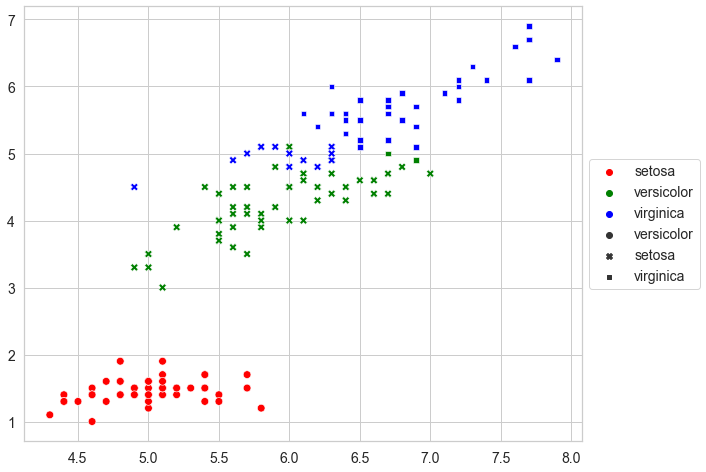

In [25]:
import sklearn.cluster as cl

df = sns.load_dataset("iris")
X = df.to_numpy()[:,0:4]
classes={0 : 'setosa', 1 : 'versicolor', 2 : 'virginica'}

km = cl.KMeans(n_clusters=3, init='k-means++').fit(X)
km_labels = [classes[i] for i in km.labels_] 

plt.figure(figsize=(10, 8))
g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=df['species'], s=60, style=km_labels,
                palette=sns.color_palette(['red', 'green', 'blue']))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

## Hard vs. soft clustering

- *Hard clustering*: each observation is assigned to exactly one cluster
- *Soft (fuzzy) clustering*: might assign an observation to multiple clusters


- *Fuzzy C-Means* replaces the assignments by probabilities for each observation to belong to each cluster
    - For instance, the fact that an observation $x_1$ is associated more with the second cluster than with the first can be expressed as  $\vec{\mu}_1 = (0.2, 0.8)$

## Fuzzy C-Means

Algorithm:

1. Specify $K$ centroids and randomly assign the cluster membership for each observation
2. Loop:
    + Recompute cluster centroids
    + Update cluster membership of observations
    \begin{equation*}
    P(\vec{x},\vec{\mu})=\left[\sum_{p=1}^K{\left(\frac{d(\vec{x},\vec{\mu})}{d(\vec{x},\vec{\mu}_p)}\right)^{\frac{2}{m-1}}} \right]^{-1}
    \end{equation*}
    where $m>1$ is a *fuzziness coefficient* 
    + Repeat until the centroids do not change (up to some given tolerance threshold)

## Determine the number of clusters

+ Finding a correct $K$ is quite hard because of the unknown labels -- no data to test
+ Elbow plot:
    - Compute K-means for different $K$, say from $K=1,\dots,10$
    - Get the within-cluster similarity for each $K$ (distortion)
    - Plot the distortions and select the number of clusters at which an elbow can be observed
+ Hierarchical clustering is another possibility

## DBSCAN
+ Classify observations based on their density in the feature space
+ Makes no assumption on a shape of clusters
+ DBSCAN assigns a label to each observation as follows:
    - **Core point**: at least a specified number of points *MinPts* are within the specified radius $\epsilon$
    - **Border point**: an observation that has fewer observations in the radius $\epsilon$ than *MinPts*, but is in the radius of a core point
    - **Noise point**: all other points

## Algorithm

1. Create a separate cluster for every set of core points such that every point of this set is in the $\epsilon$ radius of other core points of the same set
2. Assign each border element to a cluster, where its core point is

- Possible disadvantages:
    + High number of features wrt. the number of observations might result in reduction of performance
    + Selection of hyperparameters *MinPts* and $\epsilon$ can be problematic
- Spectral clustering methods: use PCA-like approach and focus on spectrum (eigenvalues) of the similarity matrix, to perform dimensionality reduction prior to clustering

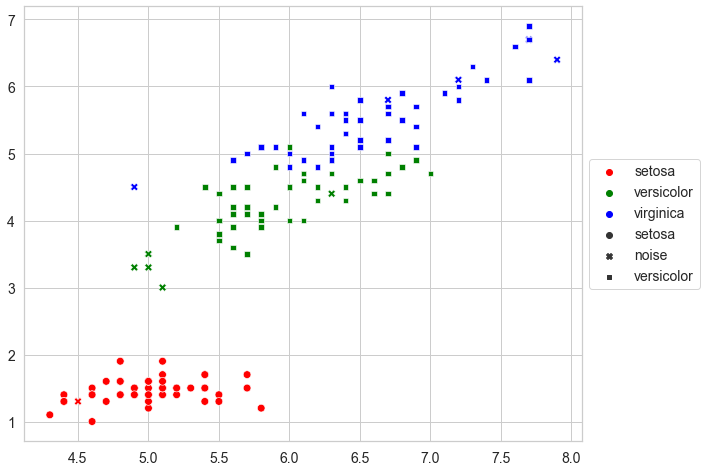

In [26]:
df = sns.load_dataset("iris")
X = df.to_numpy()[:,0:4]
classes={-1: 'noise', 0 : 'setosa', 1 : 'versicolor', 2 : 'virginica', 3:'unknown'}

db = cl.DBSCAN(eps=0.55, metric='euclidean').fit(X)
db_labels = [classes[i] for i in db.labels_] 

plt.figure(figsize=(10, 8))
g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=df['species'], s=60, style=db_labels,
                palette=sns.color_palette(['red', 'green', 'blue']))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

## Hierarchical clustering

+ Hierarchical clustering is an approach which does not require any parameters
+ Can be of two types: bottom-up or agglomerative as well as top-down or divisive
+ Here we consider the agglomerative variant, which is the most common type of hierarchical clustering
+ Dendrogram is built starting from the leaves and combining clusters up to the trunk

## Agglomerative clustering

**Algorithm**:

1. Start with each point in its own cluster
2. Identify the closest two clusters wrt. within-cluster variation measure and merge them 
3. Repeat until all points are in a single cluster

## Example

- Suppose we have a generated data with three classes, shown in green, purple and orange
- How can we discover them from data?
<center>
    <img src="images/hier_1.jpg" width="40%"/>
</center>
<p style="text-align:right">Copyright: ISLR</p>

## Example, cont.

+ Complete dendrogram obtained using Euclidean distance and complete linkage, when the maximum distance is measured among all elements of a cluster 
+ Cuts at 9 and 5 allow to get the number of clusters

<center>
    <img src="images/hier_2.jpg" width="60%"/>
</center>
<p style="text-align:right">Copyright: ISLR</p>

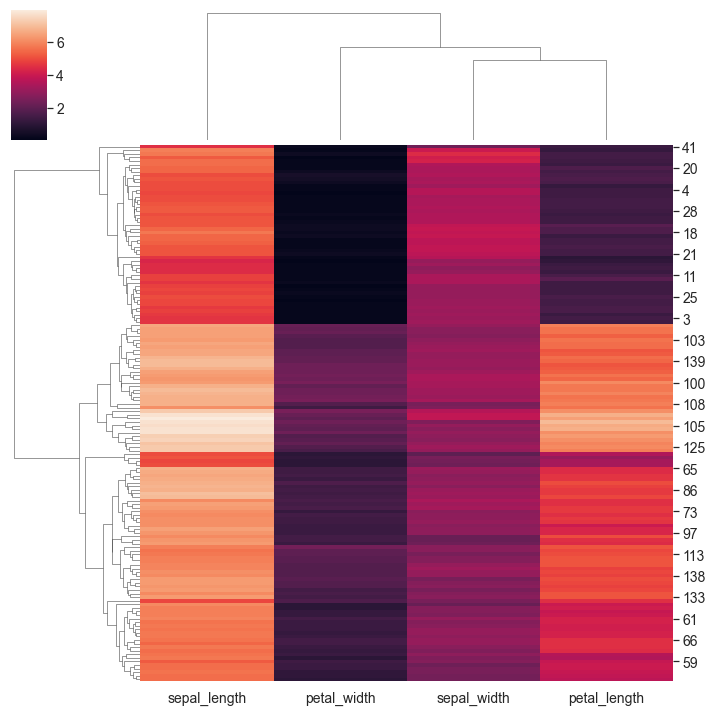

In [27]:
df = sns.load_dataset("iris")
df.pop('species')
g = sns.clustermap(df)